In [13]:
import numpy as np

import keras
keras.__version__

'2.2.4'

# Classifying movie reviews: a binary classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

Documents in this dataset vary by length (i.e. the number of words). We also need to know the maximum length of sentences. Then we make the documents in uniform length by truncating long documents and padding short ones.

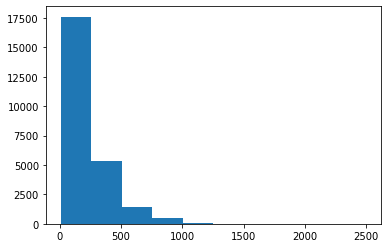

In [7]:
from matplotlib import pyplot as plt
plt.hist([len(doc) for doc in train_data])
plt.show()



In [9]:
DOC_LEN = 500
MAX_WORDS = 10000

train_x = keras.preprocessing.sequence.pad_sequences(
    train_data, maxlen = DOC_LEN, dtype='int32', \
    padding='post', truncating='post', value=0.0)

test_x = keras.preprocessing.sequence.pad_sequences(
    test_data, maxlen = DOC_LEN, dtype='int32', \
    padding='post', truncating='post', value=0.0)

print(train_x.shape)
print(test_x.shape)

(25000, 500)
(25000, 500)


For kicks, here's how you can quickly decode one of these reviews back to English words:

In [10]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [11]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

We should also vectorize our labels, which is straightforward:

In [14]:
# Our vectorized labels
train_y = np.asarray(train_labels).astype('float32')
test_y = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network

The CNN architecture for text classification can be explained as followed:

- Assume $m$ samples, each of which is a sentence with $n$ words (short sentences can be padded)
- **Embedding**: In each sentence, each word can be represented as its word vector of dimension $d$ (pretrained or to be trained)
- **Convolution**: Apply filters to n-grams of different lengths (e.g. unigram, bigrams, ...). 
   - E.g. A filter can slide through every 2 words (bigram)
   - So, the filter size (i.e. region size) can be $1\text{x}d$ (unigram), $2\text{x}d$ (bigram), $3\text{x}d$ (trigram), ...
- At pooling layer, 1-max pooling is applied to the result of each filter. Then all results after pooling are concatenated as the input to the output layer
  - This is equivalent to select words or phrases that are **discriminative** with regard to the classification goal

<img src='http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-12.05.40-PM.png' width='70%'>

*Illustration of a Convolutional Neural Network (CNN) architecture for sentence classification. Here we depict three filter region sizes: 2, 3 and 4, each of which has 2 filters. Every filter performs convolution on the sentence matrix and generates (variable-length) feature maps. Then 1-max pooling is performed over each map, i.e., the largest number from each feature map is recorded. Thus a univariate feature vector is generated from all six maps, and these 6 features are concatenated to form a feature vector for the penultimate layer. The final softmax layer then receives this feature vector as input and uses it to classify the sentence; here we assume binary classification and hence depict two possible output states. Source: Zhang, Y., & Wallace, B. (2015). A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification.*



Our network will have the following layers:
- A embedding layer maps each word to a vector. A few options for configuring the word vectors:
    - (a) Randomly `initialize the embedding layer and train the word vector as a part of the network`
    - (b) Populate the embedding layer with pretrained word vectors, e.g. Glove, Google word vectors, and make this layer `non-trainable`
    - (c) Initialize the embedding layer with pretrained word vectors, but `train the word vector continuously`
    - `Discussion: what are the pros and cons of each option?`
- Three covolution layers with different filter sizes
- A maxpooling layer (MaxPooling1D) following each convolution layer
- A concatenate layer to merge the output layer of each maxpooling layer
- A dense layer to produce final output
Let's first try option (a), where word vectors are randomly initialized and trained as part of the CNN

In [16]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model

# The dimension for embedding
EMBEDDING_DIM=100

# define input layer, where a sentence represented as
# 1 dimension array with integers
main_input = Input(shape=(DOC_LEN,), dtype='int32', name='main_input')

# define the embedding layer
# input_dim is the size of all words (including the padding symbol)
# output_dim is the word vector dimension
# input_length is the max. length of a document
# input to embedding layer is the "main_input" layer
embed_1 = Embedding(input_dim = MAX_WORDS, \
                    output_dim = EMBEDDING_DIM, \
                    input_length = DOC_LEN,\
                    name='embedding')(main_input)


# define 1D convolution layer
# 64 filters are used
# a filter slides through each word (kernel_size=1)
# input to this layer is the embedding layer
conv1d_1= Conv1D(filters=64, kernel_size=1, \
                 name='conv_unigram',\
                 activation='relu')(embed_1)

# define a 1-dimension MaxPooling 
# to take the output of the previous convolution layer
# the convolution layer produce 
# DOC_LEN-1+1 values as ouput (do you know why)
pool_1 = MaxPooling1D(DOC_LEN-1+1, \
                      name='pool_unigram')(conv1d_1)

# The pooling layer creates output 
# in the size of (# of sample, 1, 64)  
# remove one dimension since the size is 1
flat_1 = Flatten(name='flat_unigram')(pool_1)

# following the same logic to define 
# filters for bigram
conv1d_2= Conv1D(filters=64, kernel_size=2, \
                 name='conv_bigram',\
                 activation='relu')(embed_1)
pool_2 = MaxPooling1D(DOC_LEN-2+1, name='pool_bigram')(conv1d_2)
flat_2 = Flatten(name='flat_bigram')(pool_2)

# filters for trigram
conv1d_3= Conv1D(filters=64, kernel_size=3, \
                 name='conv_trigram',activation='relu')(embed_1)
pool_3 = MaxPooling1D(DOC_LEN-3+1, name='pool_trigram')(conv1d_3)
flat_3 = Flatten(name='flat_trigram')(pool_3)

# Concatenate flattened output
z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

# Create a dropout layer
# In each iteration only 50% units are turned on
drop_1=Dropout(rate=0.5, name='dropout')(z)

# Create the output layer
preds = Dense(1, activation='sigmoid', name='output')(drop_1)

# create the model with input layer
# and the output layer
model = Model(inputs=main_input, outputs=preds)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     1000000     main_input[0][0]                 
__________________________________________________________________________________________________
conv_unigram (Conv1D)           (None, 500, 64)      6464        embedding[0][0]                  
__________________________________________________________________________________________________
conv_bigram (Conv1D)            (None, 499, 64)      12864       embedding[0][0]                  
__________________________________________________________________________________________________
conv_trigr

The model can be visualized as follows:

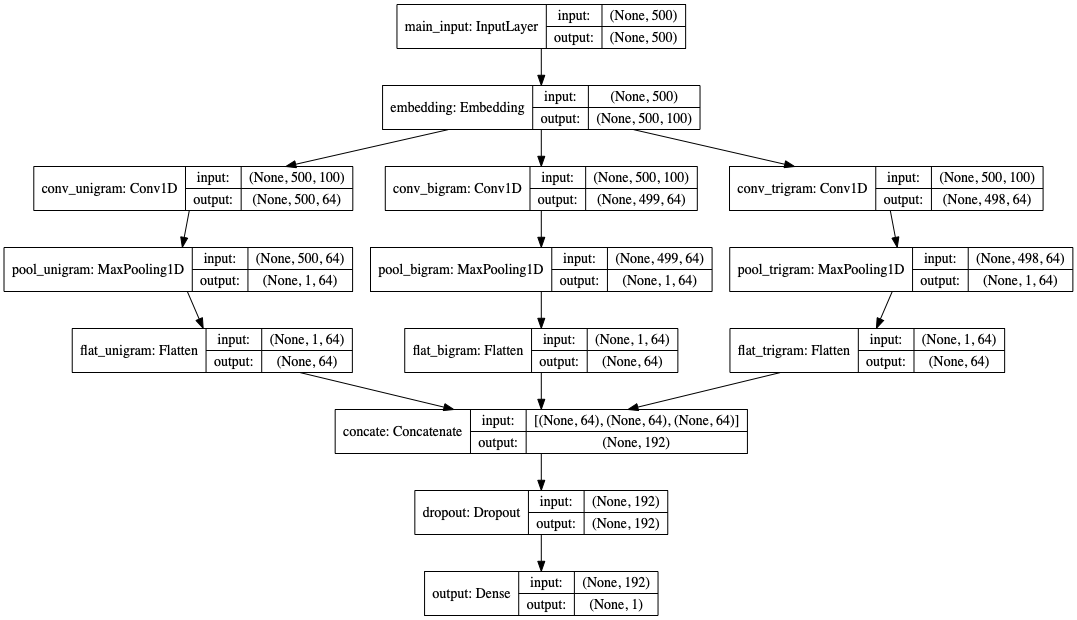

In [31]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
G = model_to_dot (model, show_shapes = True)
Image (G.create (prog = "dot", format = "png"))

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

In [18]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [19]:
val_x = train_x[:10000]
partial_train_x = train_x[10000:]

val_y = train_y[:10000]
partial_train_y = train_y[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [20]:
history = model.fit(partial_train_x,
                    partial_train_y,
                    epochs=20,
                    batch_size=128,
                    validation_data=(val_x, val_y))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 16s 1ms/step - loss: 0.5690 - acc: 0.7279 - val_loss: 0.4237 - val_acc: 0.8275
Epoch 2/20
15000/15000 [==============================] - 15s 997us/step - loss: 0.3825 - acc: 0.8365 - val_loss: 0.3349 - val_acc: 0.8639
Epoch 3/20
15000/15000 [==============================] - 15s 993us/step - loss: 0.3084 - acc: 0.8736 - val_loss: 0.3004 - val_acc: 0.8775
Epoch 4/20
15000/15000 [==============================] - 15s 988us/step - loss: 0.2656 - acc: 0.8941 - val_loss: 0.2829 - val_acc: 0.8850
Epoch 5/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.2268 - acc: 0.9114 - val_loss: 0.2772 - val_acc: 0.8855
Epoch 6/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.1964 - acc: 0.9265 - val_loss: 0.2835 - val_acc: 0.8817
Epoch 7/20
15000/15000 [==============================] - 15s 1ms/step - loss: 0.1684 - acc: 0.9361 - val_loss: 0.2725 - v

Now we can plot the training and validation performance as usual:

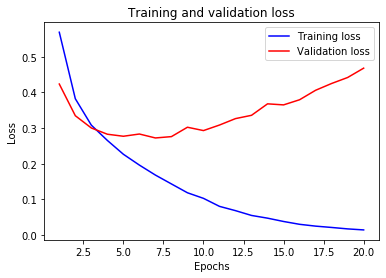

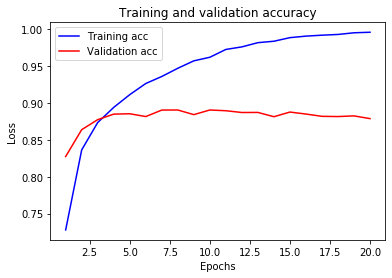

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b-', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Use Pretrained Word Vectors


For Option (b) and (c), we need to first get pre-trained word vecotors. There are two possible ways:
- If you have a large collection of documents, you can train word vectors using Skip-Gram model
- Or you can download Google or Glove word vectors.

The code sketch is provided below. Note, the code sketch just give you some idea. It may not work as is.

A good reference can be found at https://medium.com/analytics-vidhya/keras-embedding-layer-and-programetic-implementation-of-glove-pre-trained-embeddings-step-by-step-7a4b2fa71544

### Train word vectors by skip-gram model 

In [29]:
from gensim.models import word2vec
import logging

def train_skip_gram_word_vector(train_data, emb_dim):

    # print out tracking information
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                        level=logging.INFO)

    # train_data: a list of documents, and each document is a list of tokens (or words)
    # min_count: words with total frequency lower than this are ignored
    # size: the dimension of word vector
    # window: context window, i.e. the maximum distance 
    #         between the current and predicted word 
    #         within a sentence (i.e. the length of ngrams)
    # workers: # of parallel threads in training
    # for other parameters, check https://radimrehurek.com/gensim/models/word2vec.html
    wv_model = word2vec.Word2Vec(train_data, \
                min_count=5, size=emb_dim, \
                window=5, workers=4 )
    
    return wv_model

### Load pretrained word vector model (e.g. Google word vector)

In [ ]:
# download the bin file for pretrained word vectors
# from above links, e.g. https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# Warning: the bin file is very big (over 2G)
# You need a powerful machine to load it

import gensim

model = gensim.models.KeyedVectors.\
load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

# A quick test to see if the word vector model works
model.wv.most_similar(positive=['women','king'], \
                      negative='man')

## Create embedding matrix using pretrained wv_model

With word vector model, you can populate a embedding matrix with the following function:

- Inputs:
    - `wv_model`:   the pretrained wv_model loaded using gensim constructs. The model is like a dictionary, mapping each word to a vector
    - `emb_dim`:    embedding dimension
    - `words`:      the list of `unique words` in your vocabulary, each of which is mapped to a vector through lookup
- Output:
    - `emb_matrix`:  a matrix of size (`max_words`, `emb_dim`). Each row represents a word vector for the word in `words`.

The row index in the emb_matrix is the ID for each word. Therefore, you need to map each word in your document to its ID. Your document should be represented as a vecotor of numbers where each number is the ID of the corresponding word.

In [ ]:
def create_emb_matrix(wv_model, emb_dim, words):
    
    max_words = len(words)
    emb_matrix = np.zeros((max_words, emb_dim))

    for word, i in enumerate(words):
        if word in wv_model.wv:
            emb_matrix[i]=wv_model.wv[word]
    return emb_matrix

## Use pretrained embedding matrix in CNN model

- In the embedding layer, set the weights to `emb_matrix`, and make it trainable (`trainable = True`) or non trainable (`trainable = False`).

In [ ]:

main_input = Input(shape=(DOC_LEN,), dtype='int32', name='main_input')

embed_1 = Embedding(input_dim = MAX_WORDS, \
                    output_dim = EMBEDDING_DIM, \
                    input_length = DOC_LEN,\
                    weights=[emb_matrix],\
                    trainable=False,\
                    name='embedding')(main_input)


conv1d_1= Conv1D(filters=64, kernel_size=1, \
                 name='conv_unigram',\
                 activation='relu')(embed_1)
pool_1 = MaxPooling1D(DOC_LEN-1+1, \
                      name='pool_unigram')(conv1d_1)
flat_1 = Flatten(name='flat_unigram')(pool_1)

conv1d_2= Conv1D(filters=64, kernel_size=2, \
                 name='conv_bigram',\
                 activation='relu')(embed_1)
pool_2 = MaxPooling1D(DOC_LEN-2+1, name='pool_bigram')(conv1d_2)
flat_2 = Flatten(name='flat_bigram')(pool_2)

conv1d_3= Conv1D(filters=64, kernel_size=3, \
                 name='conv_trigram',activation='relu')(embed_1)
pool_3 = MaxPooling1D(DOC_LEN-3+1, name='pool_trigram')(conv1d_3)
flat_3 = Flatten(name='flat_trigram')(pool_3)

z=Concatenate(name='concate')([flat_1, flat_2, flat_3])

drop_1=Dropout(rate=0.5, name='dropout')(z)
preds = Dense(1, activation='sigmoid', name='output')(drop_1)

model = Model(inputs=main_input, outputs=preds)